In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [19]:
accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_15160\667666233.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")


In [20]:
# Nastavljanje pravilnega časovnega pasu
accidents_moon['NastanekDatumCas'] = pd.to_datetime(accidents_moon['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
accidents_moon['NastanekDatumCas'] = accidents_moon['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {accidents_moon['NastanekDatumCas'].dtype}")
#display(accidents_moon)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy - zadnji krajec

Preverila bom, če se ritmičnost nesreč, ki so se zgodile med zadnjim krajcem, razlikuje od ritmičnosti ostalih nesreč.

In [21]:
# Maska za luno
moon_mask = (accidents_moon['moon_phase'] == 'Last Quarter')

accidents_last_quarter = accidents_moon[moon_mask]
# display(accidents_last_quarter)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = accidents_last_quarter['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsLastQ",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

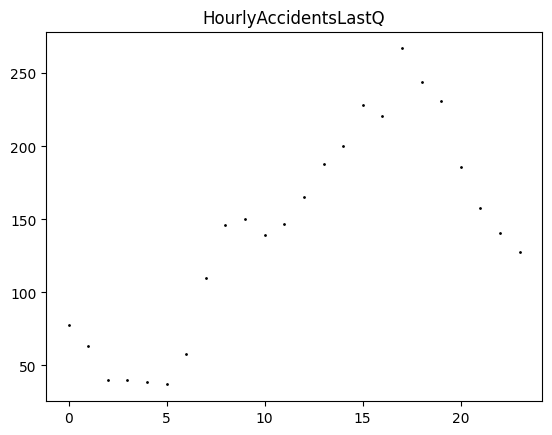

In [22]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsLastQ"])

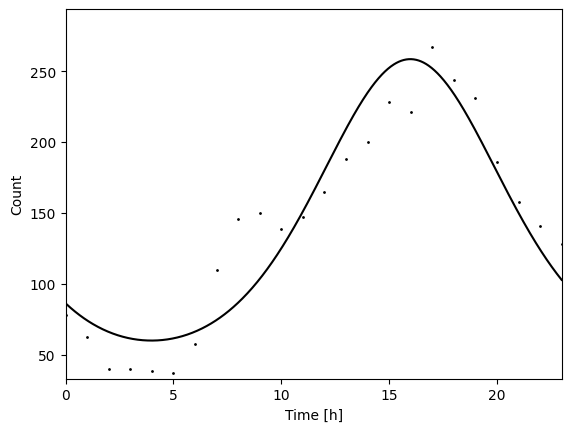

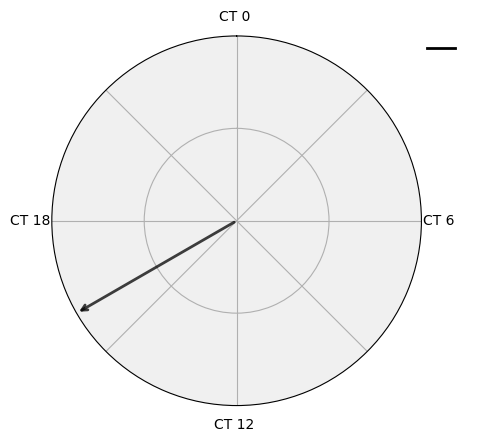

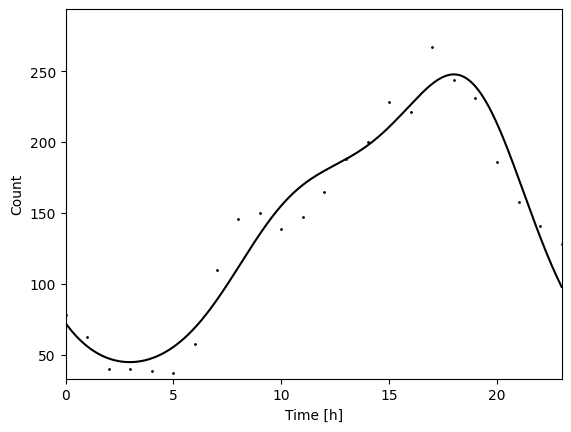

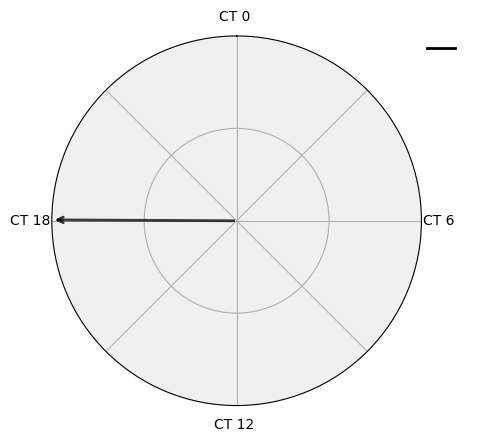

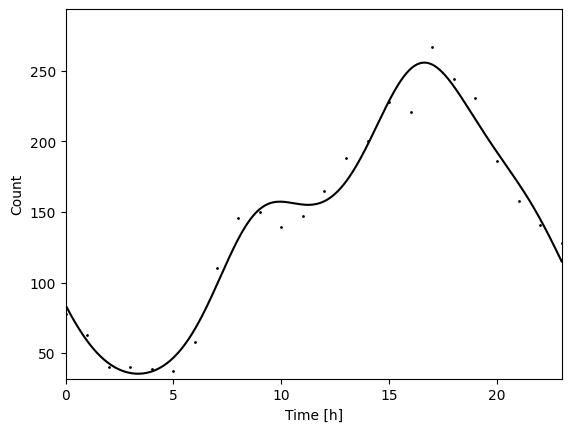

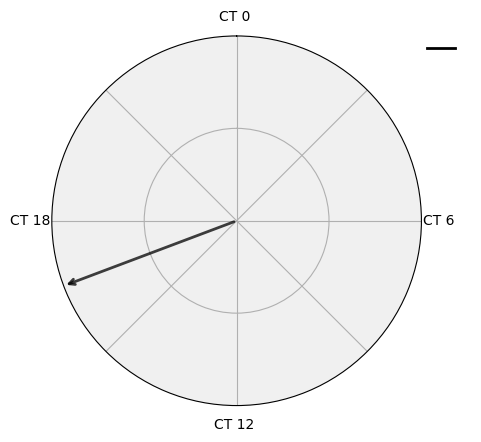

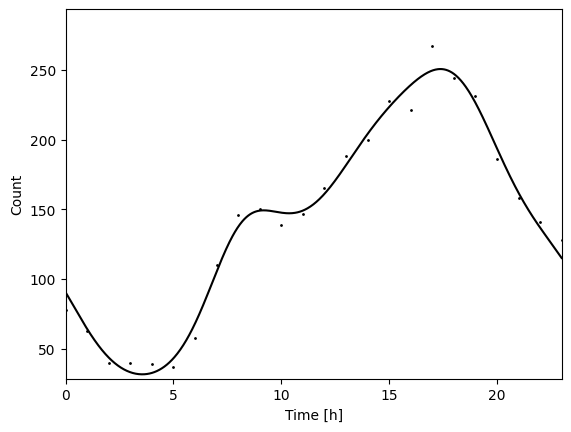

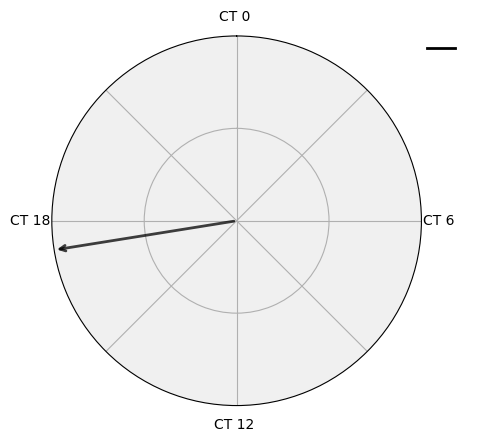

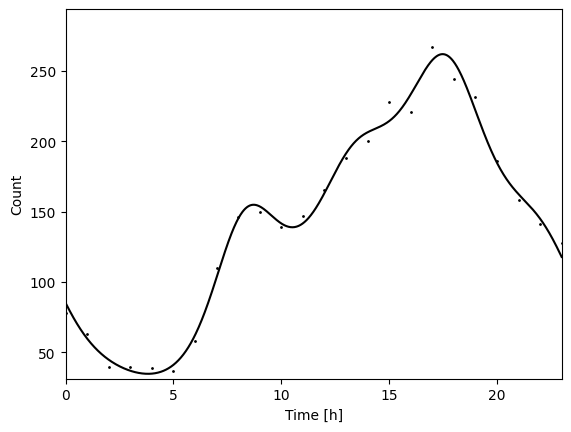

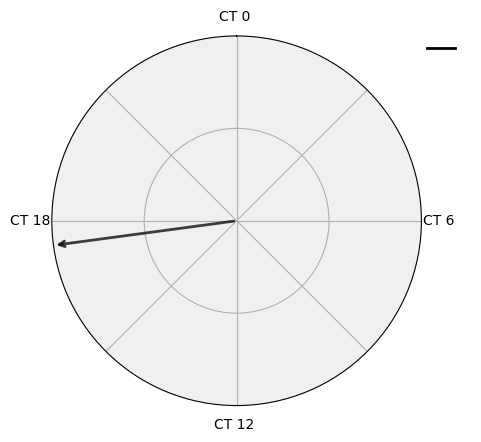

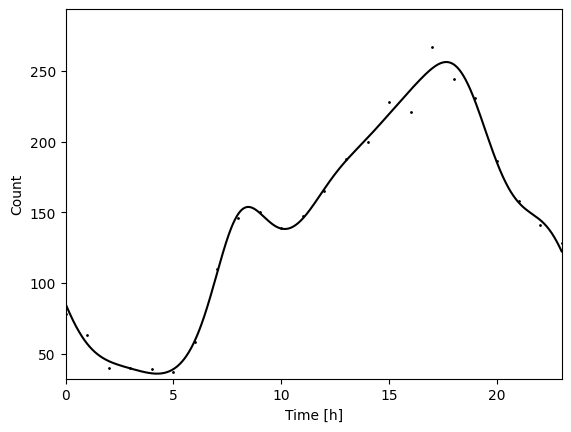

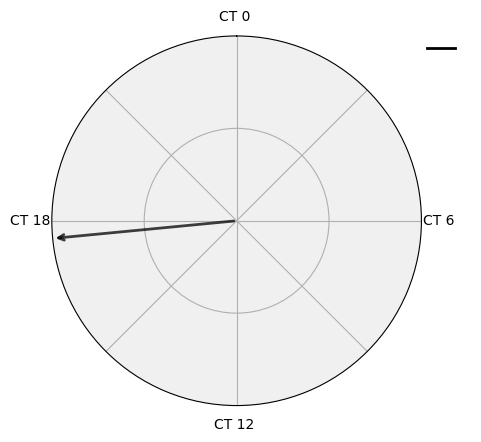

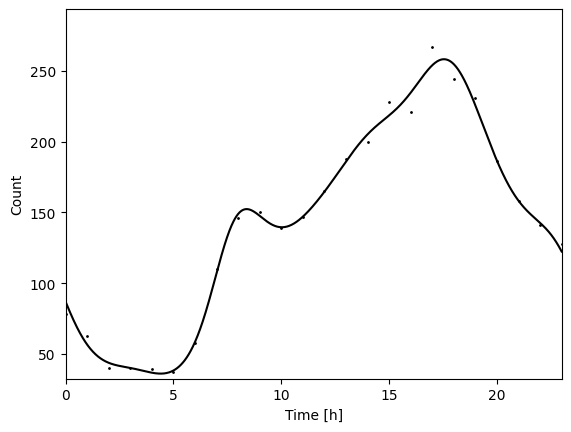

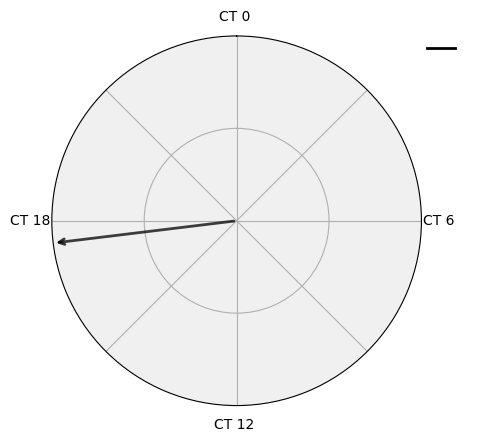

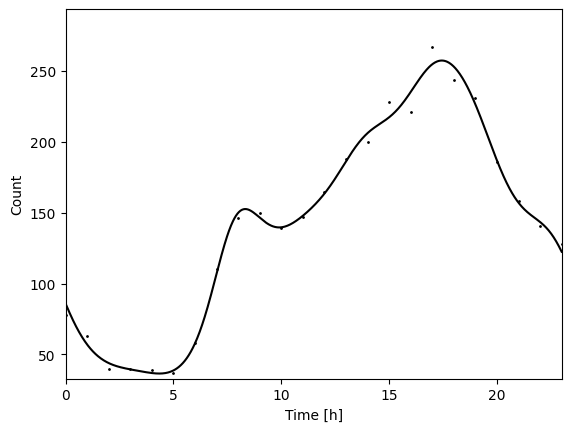

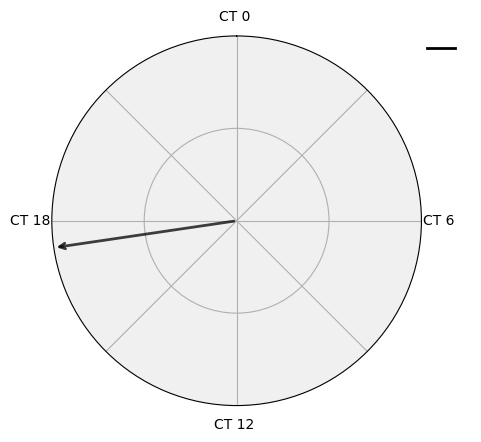

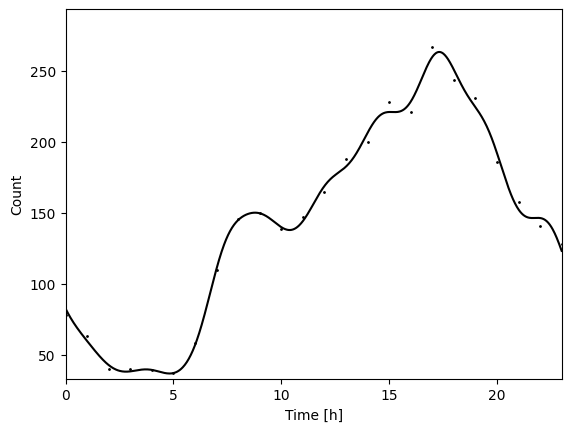

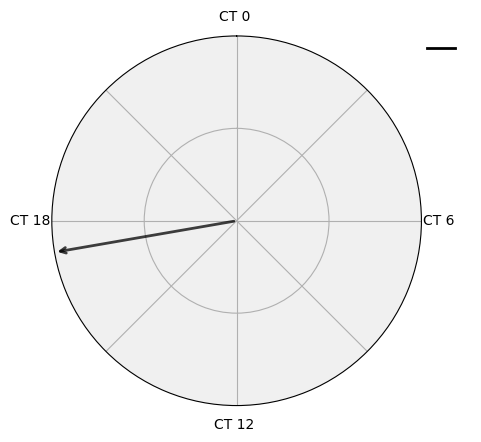

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


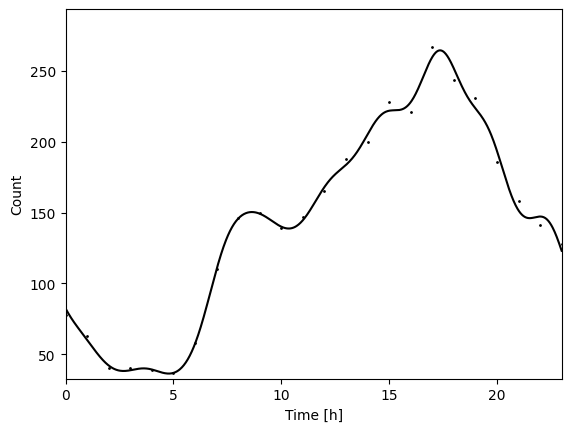

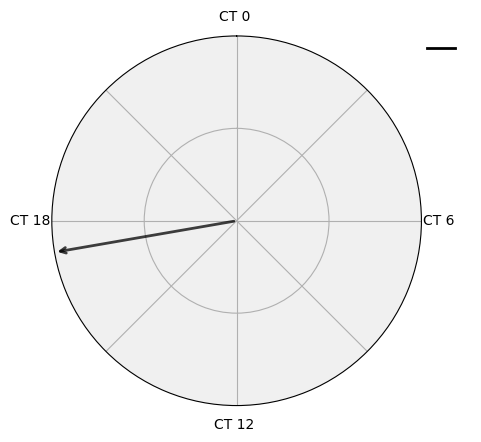

In [23]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsLastQ', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [24]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsLastQ,24.0,1.0,1.110825e-11,1.110825e-11,15339.544339,-112.288897,0.183426,99.136847,2.094395,159.321744,[16.0],[258.45671207103953],[3.987987987987988],[60.184896620342045]
1,HourlyAccidentsLastQ,24.0,2.0,6.889584e-15,7.655093e-15,6643.732655,-101.286463,0.263437,101.358811,1.566079,146.358056,[18.01801801801802],[247.71548133150063],[2.978978978978979],[44.999245077410905]
2,HourlyAccidentsLastQ,24.0,3.0,2.531783e-18,3.164728e-18,3099.469578,-89.920436,0.346091,110.204408,1.930869,145.603814,"[9.945945945945946, 16.624624624624623]","[157.29560151798552, 255.80822186338276]",[3.3633633633633635],[35.399405910595966]
3,HourlyAccidentsLastQ,24.0,4.0,2.945508e-19,4.207869e-19,1588.410786,-84.676282,0.384227,109.558203,1.729606,141.136782,"[9.177177177177176, 17.393393393393392]","[149.27563377597403, 250.69360127268052]",[3.5555555555555554],[31.578578502369645]
4,HourlyAccidentsLastQ,24.0,5.0,7.531647e-21,2.510549e-20,1097.556655,-77.937959,0.433229,113.441050,1.704448,148.317870,"[8.696696696696696, 17.48948948948949]","[154.85695727289377, 261.75891941165287]","[3.795795795795796, 10.522522522522522]","[34.878846851537766, 138.8859505553172]"
5,HourlyAccidentsLastQ,24.0,6.0,2.223076e-21,1.533395e-20,877.777241,-73.899825,0.462595,110.234475,1.666711,146.044085,"[8.456456456456456, 17.633633633633632]","[153.75982367384623, 256.2762568300443]","[4.228228228228228, 10.138138138138139]","[35.80960999553363, 138.16108091193666]"
6,HourlyAccidentsLastQ,24.0,7.0,1.194700e-20,2.986750e-20,816.698519,-73.132772,0.468173,111.112546,1.691869,147.174038,"[8.408408408408409, 17.53753753753754]","[152.35366237457686, 258.2865837601973]","[4.42042042042042, 10.042042042042041]","[36.062498727553034, 139.52620694372587]"
7,HourlyAccidentsLastQ,24.0,8.0,8.946058e-20,1.491010e-19,809.015517,-72.883701,0.469984,110.434537,1.717027,146.988211,"[8.312312312312311, 17.44144144144144]","[152.63100609566916, 257.42274828659555]","[4.324324324324325, 9.897897897897899]","[36.55462224252867, 139.6563836730198]"
8,HourlyAccidentsLastQ,24.0,9.0,3.066790e-21,1.533395e-20,503.154932,-66.683121,0.515075,113.347696,1.742185,150.149733,"[8.792792792792794, 15.03903903903904, 17.3453...","[150.18536158514928, 221.18585184751856, 263.4...","[2.7867867867867866, 4.804804804804805, 10.378...","[38.103124302626895, 36.80203676599769, 137.95..."
9,HourlyAccidentsLastQ,24.0,10.0,1.805155e-20,3.610310e-20,510.808694,-66.333293,0.517619,114.116939,1.742185,150.466676,[17.345345345345343],[264.5743653790094],"[2.6906906906906904, 4.756756756756757, 10.330...","[38.18113387961562, 36.35445078268592, 138.770..."


### Katero je najboljše število komponent

In [25]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsLastQ,24.0,4.0,2.945508e-19,4.207869e-19,1588.410786,-84.676282,0.384227,109.558203,1.729606,141.136782,"[9.177177177177176, 17.393393393393392]","[149.27563377597403, 250.69360127268052]",[3.5555555555555554],[31.578578502369645]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


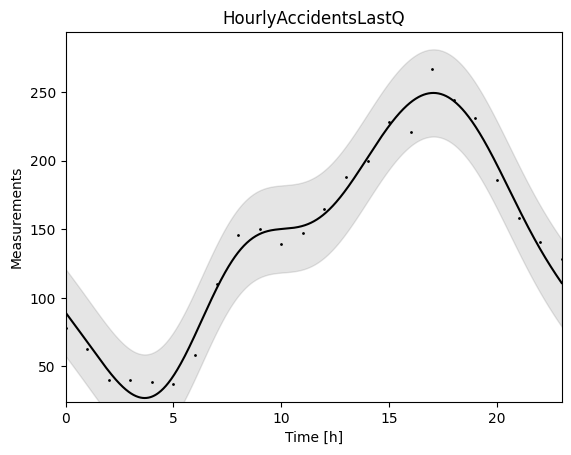

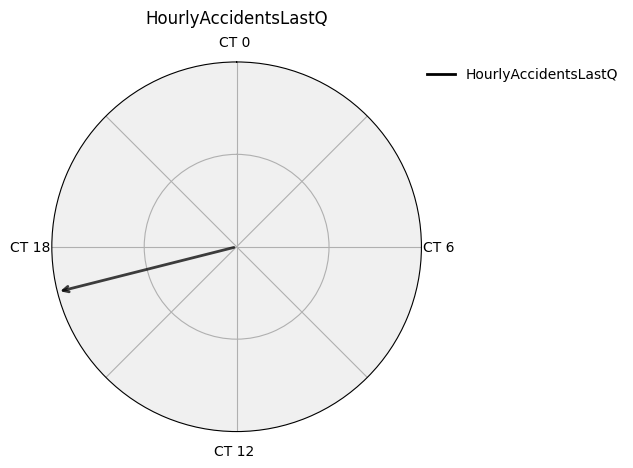

In [26]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [27]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsLastQ",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [28]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

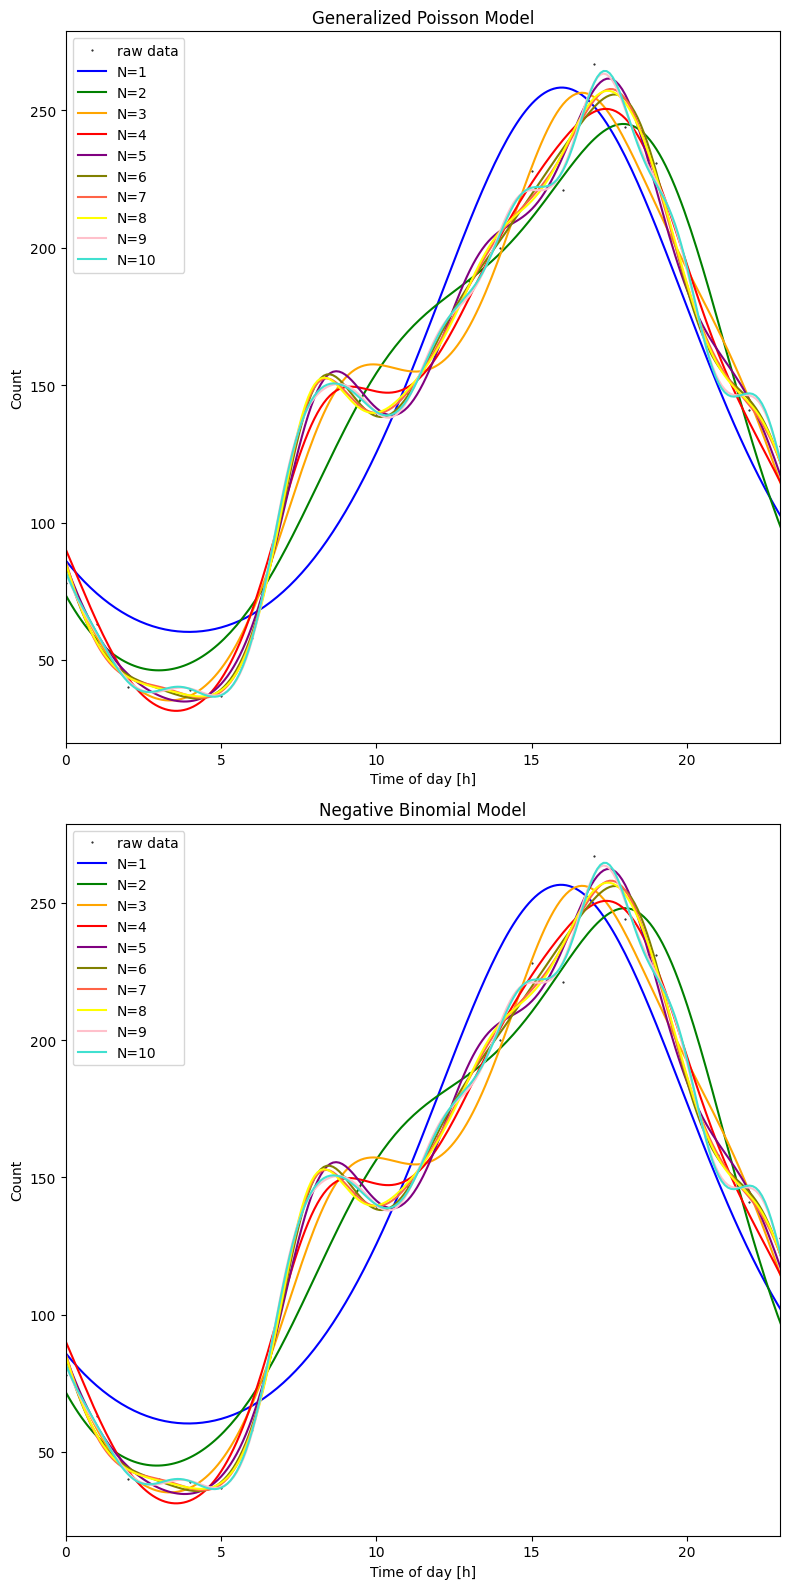

In [29]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [30]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,99.06,159.24,[16.02],[258.3],1.113767e-11,15365.931418,232.583084,237.295299,-112.291542,"[-3.9902710619873574, -3.940541561984631, -4.6...",141.779740,"[86.21715892974416, 74.20903836482512, 66.1725...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[86.21715892974416, 84.82062553727405, 83.4687..."
1,gen_poisson,2,99.43,145.62,[17.92],[245.06],8.193831e-15,6524.684237,214.929262,221.997585,-101.464631,"[-3.531415099578865, -3.4974547456855944, -3.5...",141.613606,"[73.61722309786609, 57.48208992930775, 48.8461...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[73.61722309786609, 71.61273851362668, 69.6994..."
2,gen_poisson,3,110.59,145.83,[16.62],[256.42],2.586108e-18,3112.727324,195.885155,205.309586,-89.942578,"[-3.251459238410888, -3.1017681044421153, -2.7...",141.959785,"[83.73323588175236, 58.41108041156687, 42.5389...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[83.73323588175236, 80.83461537392292, 78.0047..."
3,gen_poisson,4,109.55,141.00,[17.42],[250.55],5.492574e-19,1588.092698,190.672766,202.453304,-85.336383,"[-4.089579514495725, -2.8930510694982985, -2.8...",141.833333,"[90.30781884144405, 64.02465460340792, 43.4904...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[90.30781884144405, 87.64894665516807, 84.9735..."
4,gen_poisson,5,113.37,148.21,[17.52],[261.58],2.493221e-19,1099.465926,187.386735,201.523381,-81.693368,"[-3.3545852319511624, -2.9832710615779305, -3....",141.833333,"[84.90043295973344, 59.75121561878855, 44.8632...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[84.90043295973344, 81.90449379189597, 79.0043..."
5,gen_poisson,6,109.92,145.87,[17.72],[255.79],8.103738e-19,877.059491,188.642444,205.135197,-80.321222,"[-3.3217394958590063, -3.322640071783944, -2.9...",141.833333,"[84.57058329711315, 56.48964522942114, 44.4906...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[84.57058329711315, 80.99073405435762, 77.5552..."
6,gen_poisson,7,110.78,147.00,[17.52],[257.78],6.492071e-18,812.062619,192.212883,211.061744,-80.106441,"[-3.481907597640813, -3.4128545514274933, -2.8...",141.833333,"[86.06442198587655, 55.892576333753446, 43.550...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[86.06442198587655, 82.34454289403345, 78.7318..."
7,gen_poisson,8,110.21,146.91,[17.42],[257.12],5.137784e-17,803.549056,196.088412,217.293381,-80.044206,"[-3.3937686743043827, -3.337900594540976, -2.8...",141.833333,"[85.2763206823161, 56.384278197404846, 43.7911...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[85.2763206823161, 81.65035371828739, 78.15655..."
8,gen_poisson,9,113.17,150.20,"[15.02, 17.32]","[221.01, 263.38]",1.248168e-16,502.625881,197.536416,221.097492,-78.768208,"[-3.1346714565736136, -3.0041620664457014, -2....",141.833333,"[82.28443685166758, 59.45097654542757, 42.6399...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[82.28443685166758, 79.32481486062686, 76.5892..."
9,gen_poisson,10,113.88,150.46,[17.32],[264.35],7.927771e-16,509.694971,201.426571,227.343756,-78.713286,"[-3.1226193850297506, -2.971076922758158, -2.7...",141.833333,"[82.09795130470687, 59.94139101731733, 42.0594...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[82.09795130470687, 79.34048063644319, 76.7987..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [31]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 4


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [32]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 4
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

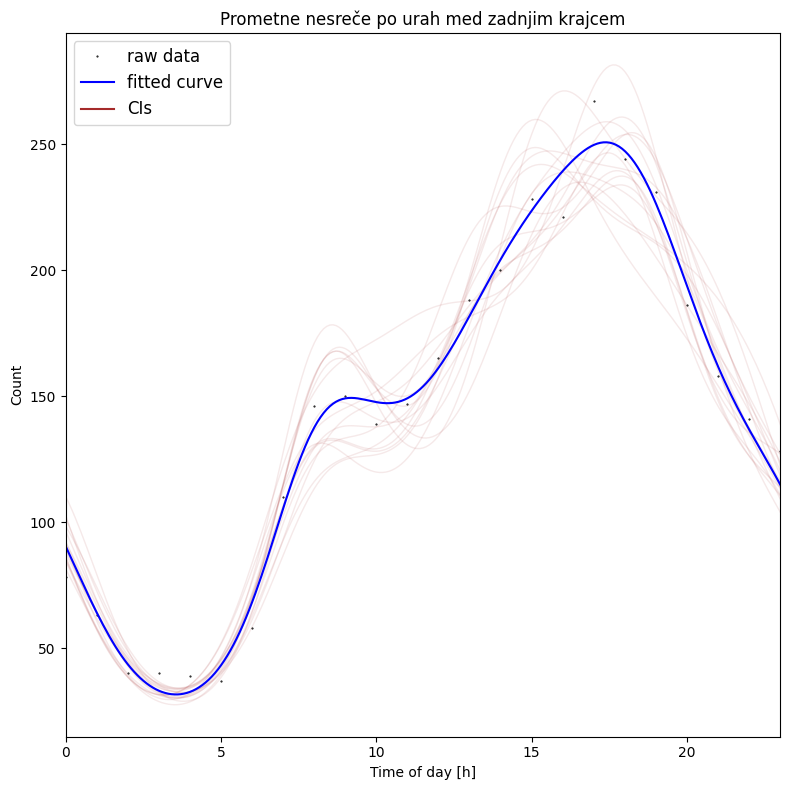

Intervali zaupanja:


,0,1
0,4.757810,4.837952
1,-0.739588,-0.601844
2,-0.530640,-0.402625
3,-0.349290,-0.235400
4,-0.093779,0.025954
5,-0.106970,0.026131
6,0.124252,0.234567
7,0.015646,0.098858
8,-0.032512,0.096439
9,-0.535110,-0.172769


In [33]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah med zadnjim krajcem', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [34]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,4
amplitude,109.55
mesor,141.0
peaks,[17.42]
heights,[250.55]
amplitude_CIs,"[95.76, 126.42]"
mesor_CIs,"[126.96, 157.48]"
peaks_CIs,"[15.98, 18.77]"
heights_CIs,"[214.56, 289.76]"
